<a href="https://colab.research.google.com/github/shu7620/Covid-19_detection_using_CNN/blob/main/notebookb00cc0dae8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tawsifurrahman_covid19_radiography_database_path = kagglehub.dataset_download('tawsifurrahman/covid19-radiography-database')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **1. Import libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow.keras import layers,models
import keras
from keras.models import Model,Sequential
from keras.layers import Conv2D,MaxPool2D
from keras.layers import Dense,BatchNormalization,Dropout,Flatten,Activation
from keras.optimizers import Adam
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder

# **2. Data Loading**

In [ ]:
#Image Paths
imagePaths=[]
for dirname,_,filenames in os.walk('/kaggle/input'):
    # Only process files inside the 'images' folder
    if 'images' in dirname:
        for filename in filenames:
            if filename.endswith('png'):  # Consider only PNG files
                imagePaths.append(os.path.join(dirname, filename))

# **3. Data Preprocessing**

In [ ]:
from tqdm import tqdm
import cv2

Data=[]
Target=[]
resize=150

#Label mapping dictionary
cat = {'Viral Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19'}

#Iterate through the image paths and assign the labels
for imagePath in tqdm(imagePaths):
    label=imagePath.split(os.path.sep)[-3] # Extract the label from parent folder (2 levels up from image)

    if label not in cat:
         continue  # Skip this image if label is not found in dictionary

    image=cv2.imread(imagePath)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(resize,resize))/255.0  # Normalize image pixels to [0, 1]

    Data.append(image)
    Target.append(cat[label])

print(f"Processed {len(Data)} images with corresponding labels.")

100%|██████████| 21165/21165 [03:11<00:00, 110.59it/s]  

Processed 15153 images with corresponding labels.


In [ ]:
print(len(Data))
print(len(Target))

15153
15153


# **4. label Encoding**

In [ ]:
le=LabelEncoder()
labels=le.fit_transform(Target)
labels=to_categorical(labels)

print(le.classes_)
print(labels[0])

['Covid-19' 'Normal' 'Pneumonia']
[0. 1. 0.]


# **5. Splitting Dataset**

In [ ]:
#Initial Split
(x_train,x_test,y_train,y_test)=train_test_split(Data,labels,test_size=0.2,stratify=labels,random_state=42)
# Further split the training data into training and validation sets
(x_train,x_val,y_train,y_val)=train_test_split(x_train,y_train,test_size=0.2,stratify=y_train,random_state=42)

trainx=np.array(x_train)
valx=np.array(x_val)
testx=np.array(x_test)
trainy=np.array(y_train)
valy=np.array(y_val)
testy=np.array(y_test)

print("Training data shape:", trainx.shape)
print("Validation data shape:", valx.shape)
print("Testing data shape:", testx.shape)
print("Training labels shape:", trainy.shape)
print("Validation labels shape:", valy.shape)
print("Testing labels shape:", testy.shape)

Training data shape: (9697, 150, 150, 3)
Validation data shape: (2425, 150, 150, 3)
Testing data shape: (3031, 150, 150, 3)
Training labels shape: (9697, 3)
Validation labels shape: (2425, 3)
Testing labels shape: (3031, 3)


# **6. CNN Model Training**

In [ ]:
#Define the model
s=150

model=Sequential()

#Feature extraction part
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(s,s,3),kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(1,1)))
model.add(Dropout(0.25))

#Neural network(Dense layer)
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# Train the model with validation data
epochs = 25
history = model.fit(trainx, trainy, epochs=epochs, batch_size=40, verbose=1, validation_data=(valx, valy))

Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.7305 - loss: 0.8516 - val_accuracy: 0.8903 - val_loss: 0.2881
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.9012 - loss: 0.2590 - val_accuracy: 0.8998 - val_loss: 0.2490
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.9360 - loss: 0.1873 - val_accuracy: 0.9299 - val_loss: 0.1862
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.9536 - loss: 0.1264 - val_accuracy: 0.9468 - val_loss: 0.1560
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.9605 - loss: 0.1115 - val_accuracy: 0.9452 - val_loss: 0.1508
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.9702 - loss: 0.0856 - val_accuracy: 0.9427 - val_loss: 0.1635
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.9746 - loss: 0.0712 - val_accuracy: 0.9439 - val_loss: 0.1891
Epoch 8/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.9784 - loss: 0.0613 - val_accu

In [ ]:
model.save('CNN_Covid19_Xray_Version.h5')


import pickle

pickle.dump(le, open("Label_encoder.pkl",'wb'))
print("saved")

saved


# **7. Plotting History and Loss**

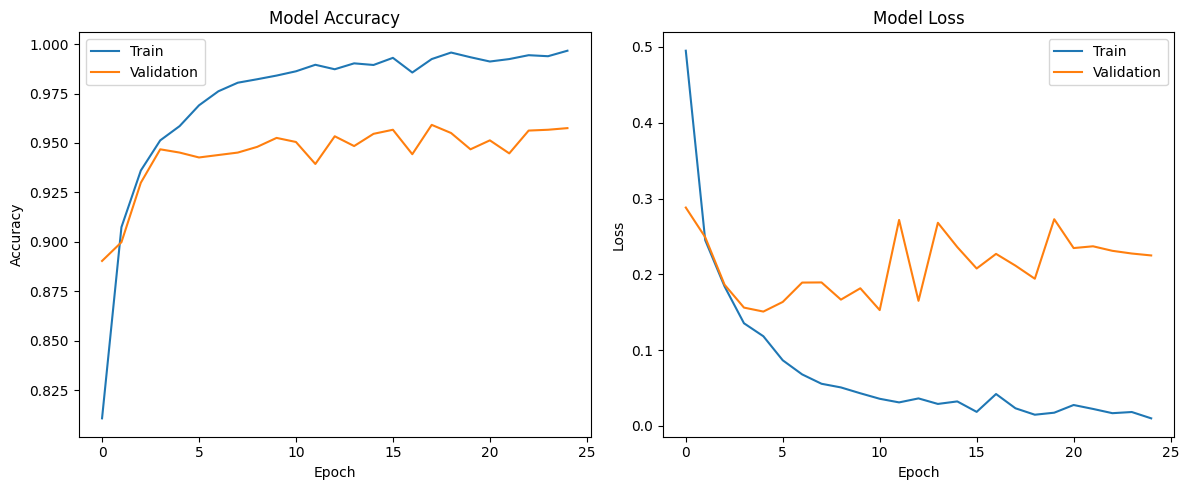

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

# **8. Plotting Confusion Matrix**

In [ ]:
# Make predictions
predictions = model.predict(testx)
y_pred = np.argmax(predictions, axis=1)  # Convert predictions to class labels

# Convert testY from one-hot encoded to class labels (integers)
y_true = np.argmax(testy, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

95/95 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step
[[ 683   37    3]
 [  66 1969    4]
 [   5   18  246]]


In [ ]:
class_names = le.classes_

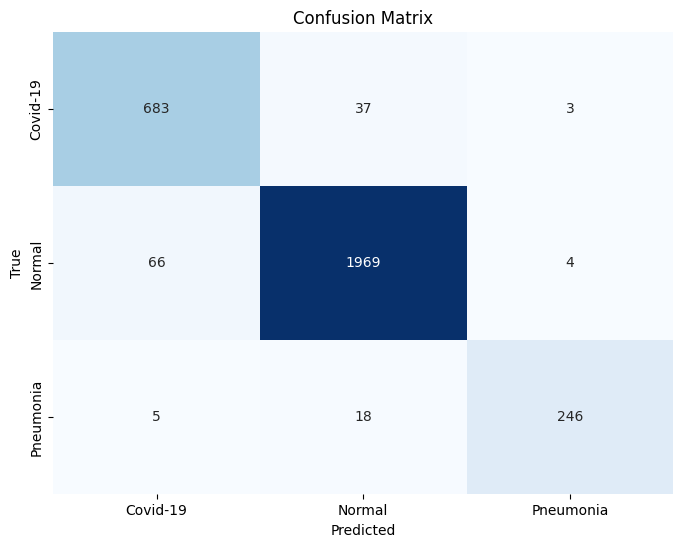

In [ ]:
# Create DataFrame for the confusion matrix
Confusion_Matrix = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(Confusion_Matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **9. Classification Report**

In [ ]:
# predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(y_true, y_pred, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.90584   0.94467   0.92485       723
      Normal    0.97283   0.96567   0.96923      2039
   Pneumonia    0.97233   0.91450   0.94253       269

    accuracy                        0.95612      3031
   macro avg    0.95033   0.94161   0.94554      3031
weighted avg    0.95680   0.95612   0.95628      3031



# **10. Prediction System**

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('CNN_Covid19_Xray_Version.h5')

le = pickle.load(open("Label_encoder.pkl",'rb'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


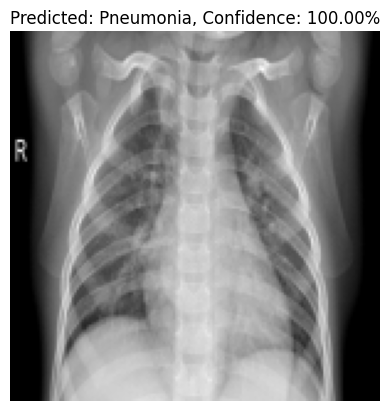

Predicted Label: Pneumonia, Confidence Score: 100.00%


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detection_system(image_path, model, label_encoder, image_size=150):
    """
    Detection system function to classify an input image.

    Parameters:
    - image_path: The path to the image to classify.
    - model: The trained Keras model.
    - label_encoder: The LabelEncoder used to encode the labels.
    - image_size: The target size for resizing the image (default: 150x150).

    Returns:
    - predicted_label: The predicted class label.
    - confidence_score: The confidence score of the predicted class.
    """
    # Load the image from the provided path
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")

    # Convert image from BGR to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to the same size as the training images
    image_resized = cv2.resize(image_rgb, (image_size, image_size))

    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_resized / 255.0

    # Expand the dimensions to match the input shape for the model
    image_input = np.expand_dims(image_normalized, axis=0)

    # Predict the class of the image
    predictions = model.predict(image_input)

    # Get the predicted class index and confidence score
    predicted_index = np.argmax(predictions)
    confidence_score = predictions[0][predicted_index]

    # Decode the predicted index back to the original label
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]


    # Display the image with the predicted label and confidence score
    plt.imshow(image_resized)
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence_score*100:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence_score

# Example usage
image_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1000.png"  # Replace with the path to your image
predicted_label, confidence_score = detection_system(image_path, model, le)
print(f"Predicted Label: {predicted_label}, Confidence Score: {confidence_score*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


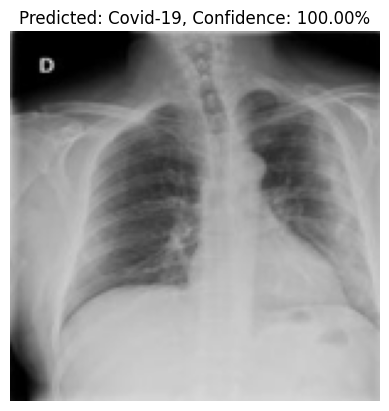

Predicted Label: Covid-19, Confidence Score: 100.00%


In [ ]:
# Example usage
image_path ="/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1019.png"
predicted_label, confidence_score = detection_system(image_path, model, le)
print(f"Predicted Label: {predicted_label}, Confidence Score: {confidence_score*100:.2f}%")